In [1]:
import os
import sys
from pathlib import Path
sys.path.append(os.path.join(Path().resolve(), '..'))

In [2]:
import copy
import pandas as pd
import pywt
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from src.module.awsom import AWSOM

def plot(sigs, title="", figsize=(21, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    for sig in sigs:
        ax.plot(sig)
    ax.set_title(title)
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.tick_params(axis="both")
    fig.tight_layout()
    return fig, ax

def generate_mix(length=40000, period=256, amplitude=50):

    amp = amplitude / 2
    period = int(period / 2)

    square = np.concatenate([np.full(period, amp), np.full(period, -amp)])
    n_square = np.ceil(length / period / 2).astype(int)
    squares = np.tile(square, (n_square,))

    sine = .25 * amplitude * np.sin(np.linspace(0, 2 * np.pi, int(period / 2)))
    n_sine = np.ceil(len(squares) / len(sine)).astype(int)
    sines = np.tile(sine, (n_sine,))

    return squares + sines

def generate_impulses(length=40000, period=256, peak=200):

    impulses = np.zeros(int(length))
    impulses[np.arange(0, int(length), period)] = peak

    return impulses

## DWT tutorial

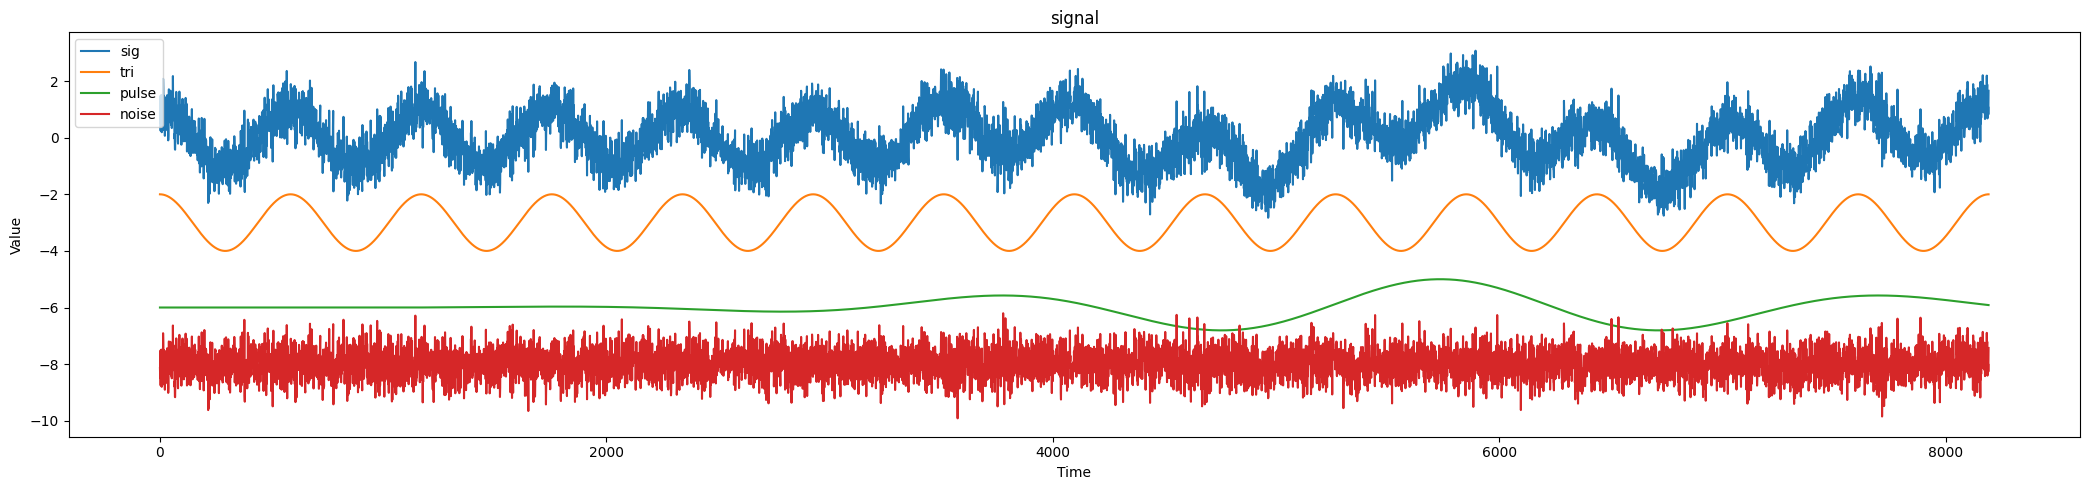

In [3]:
# signal
t = np.linspace(-1, 1, 2**13, endpoint=False)
tri = np.cos(2 * np.pi * 7 * t)
pulse = signal.gausspulse(t - 0.4, fc=2)
noise = np.random.normal(0,0.5,np.size(t))

tutorial  =  tri + pulse + noise

plot([tutorial, tri-3, pulse-6, noise-8], title="signal")
plt.legend(['sig', 'tri', 'pulse', 'noise'])

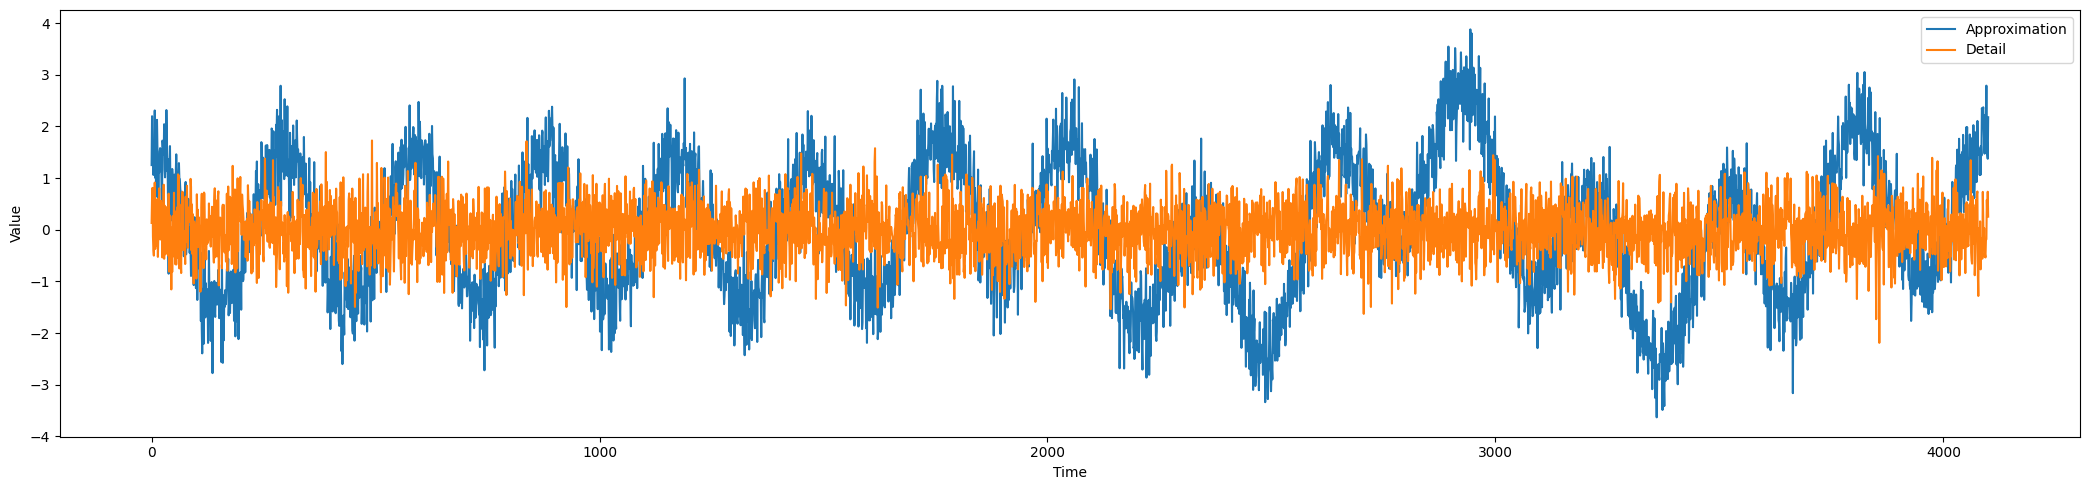

In [4]:
# DWT
width = np.arange(1, 31)
cA, cD = pywt.dwt(tutorial, 'db6')
plot([cA, cD])
plt.legend(['Approximation', 'Detail'])

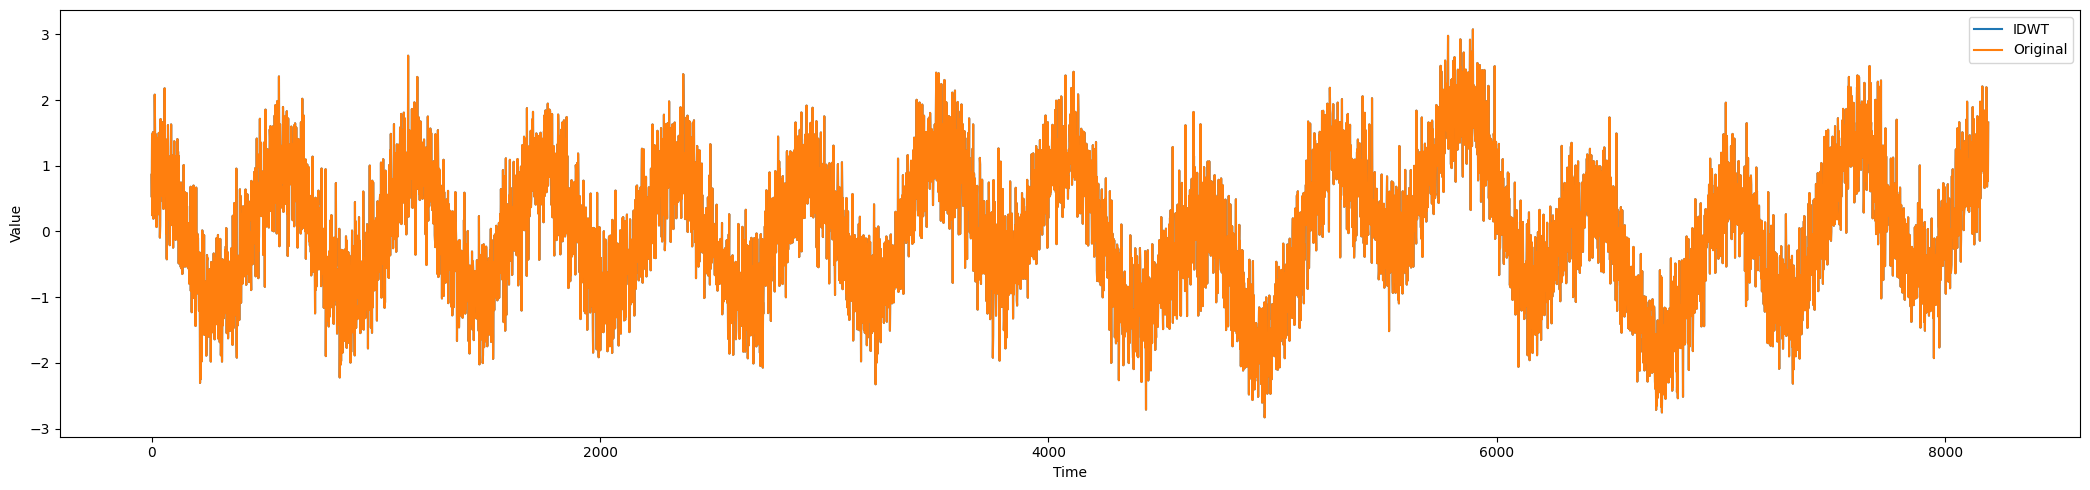

In [5]:
# IDWT
sig_r1 = pywt.idwt(cA, None ,'db6','smooth')
sig_r2 = pywt.idwt(None, cD ,'db6','smooth')
plot([sig_r1 + sig_r2, tutorial])
plt.legend(['IDWT', 'Original'])

## Experiment

(<Figure size 2100x500 with 1 Axes>,
 <Axes: title={'center': 'Mix'}, xlabel='Time', ylabel='Value'>)

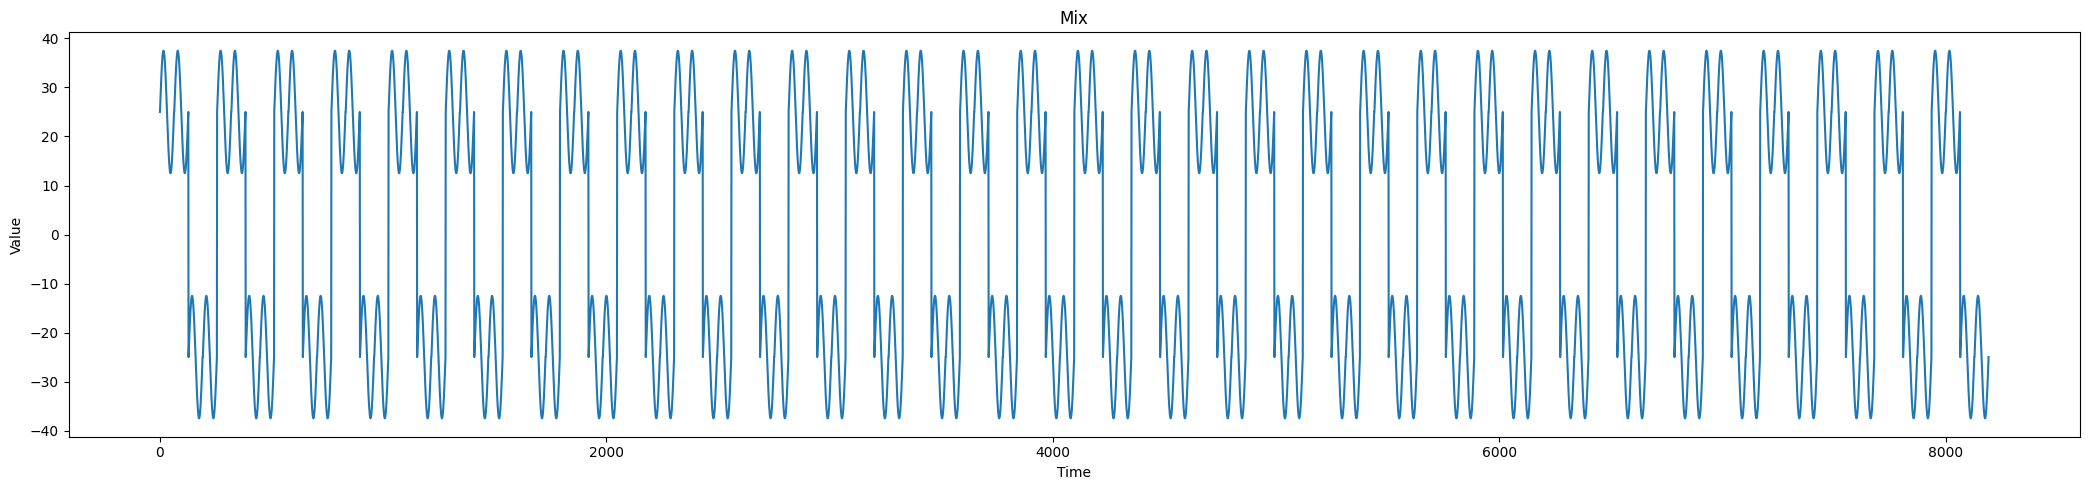

In [6]:
mix = generate_mix(length=2**13)
plot([mix], title="Mix")

(<Figure size 2100x500 with 1 Axes>,
 <Axes: title={'center': 'Impulse'}, xlabel='Time', ylabel='Value'>)

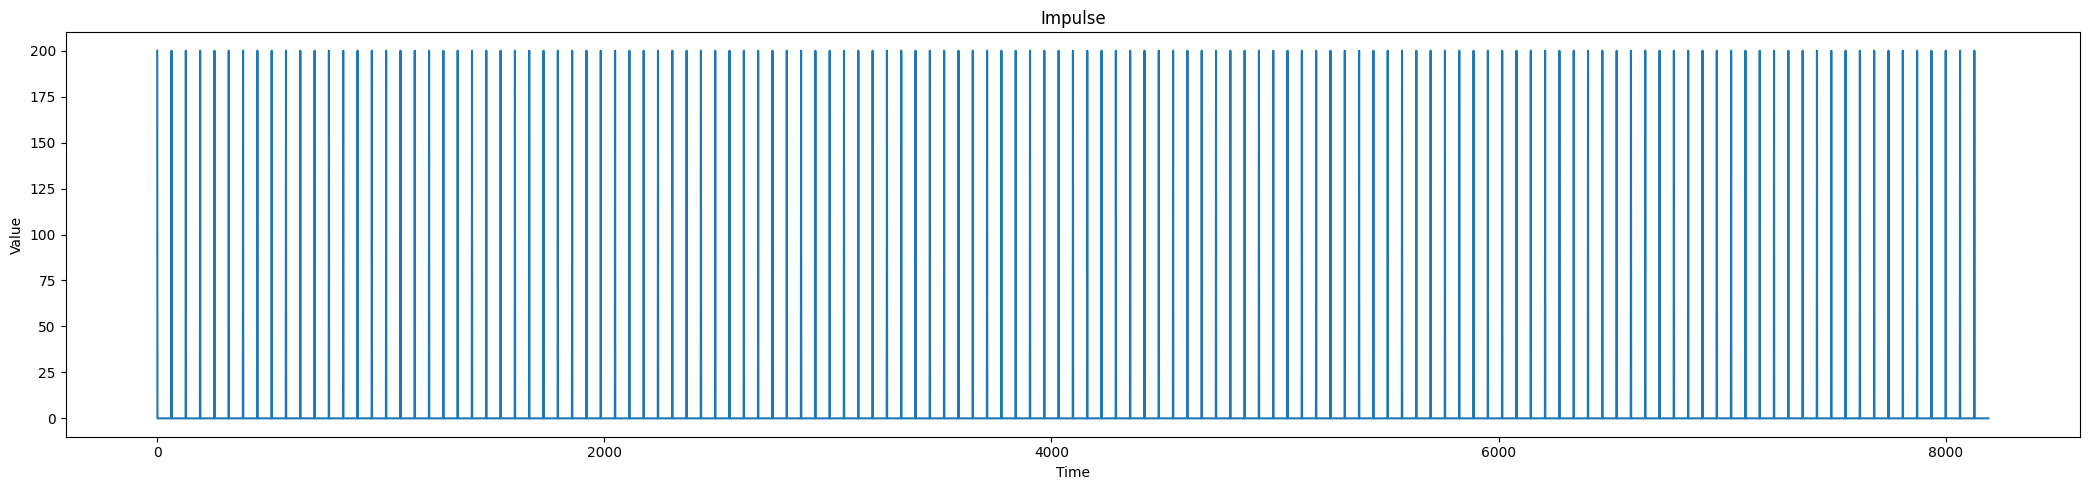

In [7]:
impulse = generate_impulses(length=2**13, period=64)
plot([impulse], title="Impulse")

(<Figure size 2100x500 with 1 Axes>, <Axes: xlabel='Time', ylabel='Value'>)

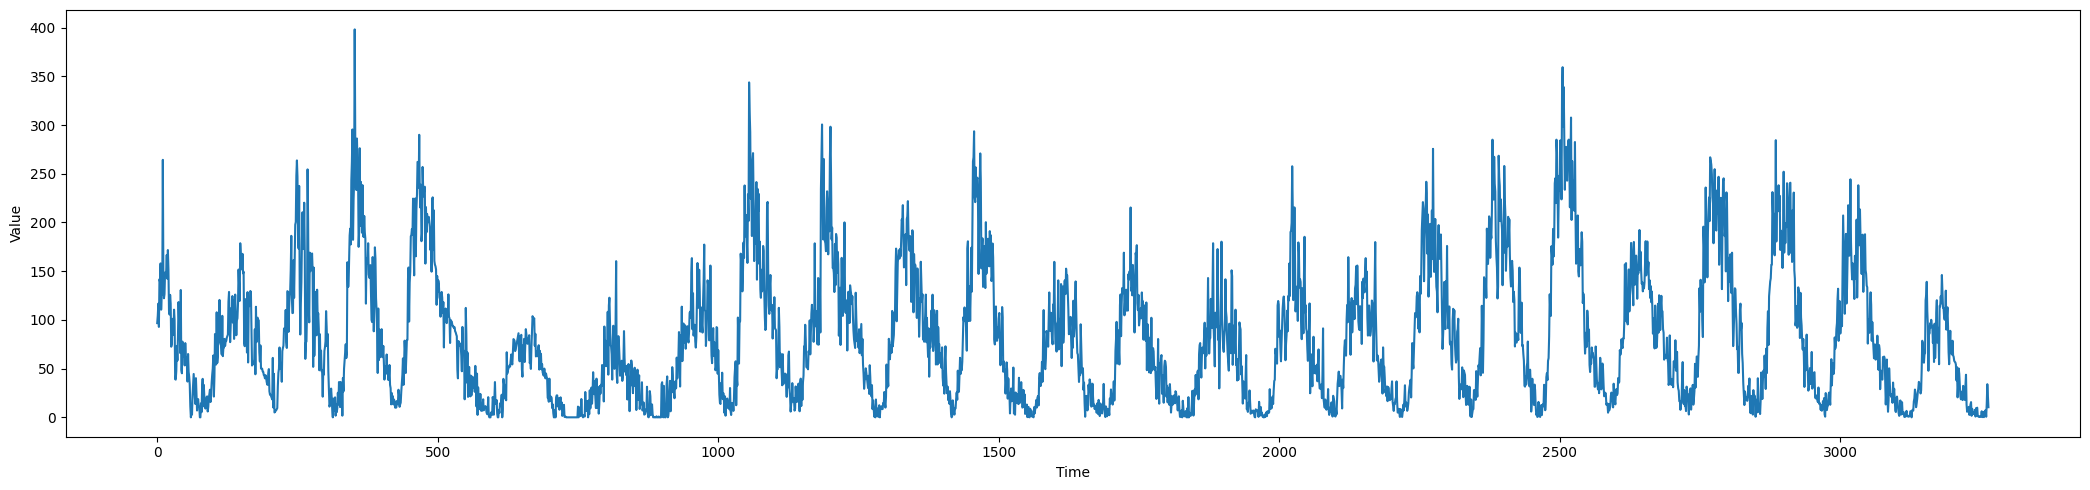

In [8]:
df = pd.read_csv('../data/Sunspots.csv')
X = df['Monthly Mean Total Sunspot Number'].values
sunspots = df['Monthly Mean Total Sunspot Number']
plot([df['Monthly Mean Total Sunspot Number']])

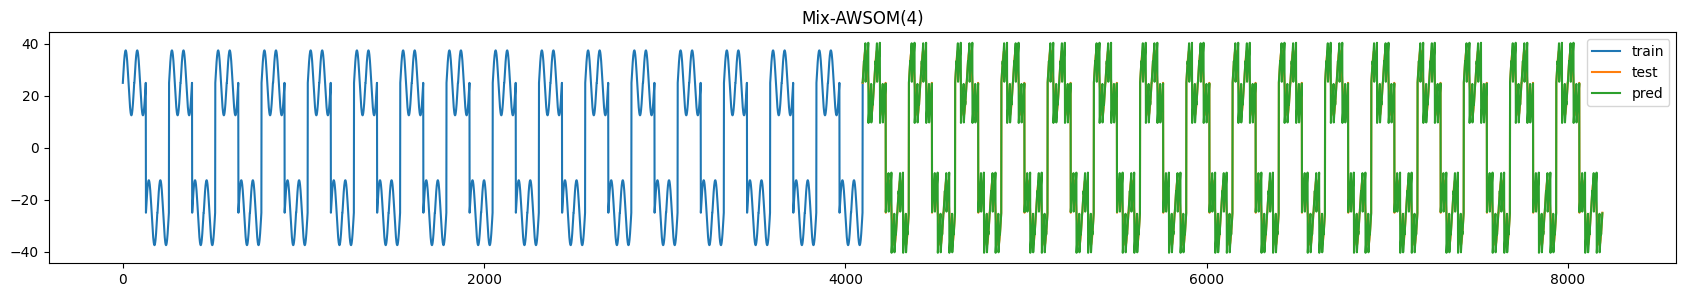

In [9]:
n_ls = [4]
sig = mix
base_point, update_point, test_point = len(sig)//4, len(sig)//2, len(sig)

awsom = AWSOM(n_ls=n_ls, dwt_type="haar")
awsom.init_params(sig[:base_point])

old_t = awsom.current_t
for t in range(base_point, update_point):
    awsom.update(sig[t])

pred = awsom.predict(update_point, interval=test_point-update_point)
plt.figure(figsize=(21, 3))
plt.title(f"Mix-AWSOM({n_ls[0]})")
plt.plot(np.arange(update_point+1), sig[:update_point+1])
plt.plot(np.arange(update_point, test_point), sig[update_point:])
plt.plot(np.arange(update_point, test_point), pred)

plt.legend(["train", "test", "pred"])

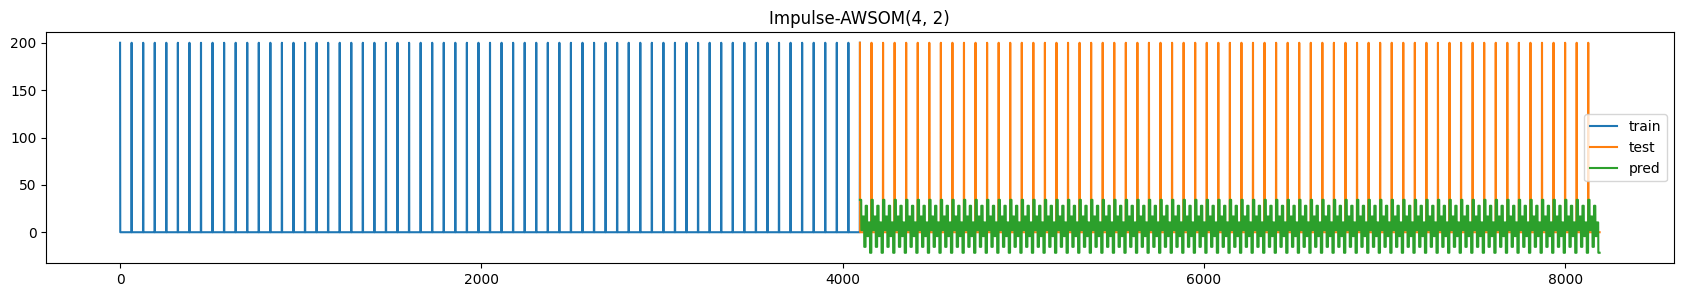

In [10]:
n_ls = [4, 2]
sig = impulse
base_point, update_point, test_point = len(sig)//4, len(sig)//2, len(sig)

awsom = AWSOM(n_ls=n_ls, dwt_type="haar")
awsom.init_params(sig[:base_point])

old_t = awsom.current_t
for t in range(base_point, update_point):
    awsom.update(sig[t])

pred = awsom.predict(update_point, interval=test_point-update_point)
plt.figure(figsize=(21, 3))
plt.title(f"Impulse-AWSOM(4, 2)")
plt.plot(np.arange(update_point+1), sig[:update_point+1])
plt.plot(np.arange(update_point, test_point), sig[update_point:])
plt.plot(np.arange(update_point, test_point), pred)

plt.legend(["train", "test", "pred"])

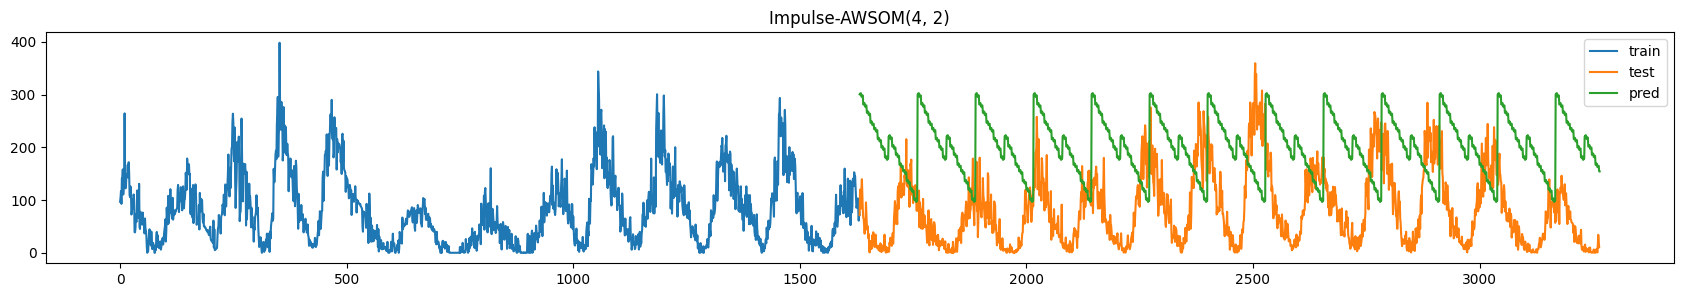

In [11]:
n_ls = [5]
sig = sunspots
base_point, update_point, test_point = len(sig)//4, len(sig)//2, len(sig)

awsom = AWSOM(n_ls=n_ls, dwt_type="haar")
awsom.init_params(sig[:base_point])

old_t = awsom.current_t
for t in range(base_point, update_point):
    awsom.update(sig[t])

pred = awsom.predict(update_point, interval=test_point-update_point)
plt.figure(figsize=(21, 3))
plt.title(f"Impulse-AWSOM(4, 2)")
plt.plot(np.arange(update_point+1), sig[:update_point+1])
plt.plot(np.arange(update_point, test_point), sig[update_point:])
plt.plot(np.arange(update_point, test_point+1), pred)

plt.legend(["train", "test", "pred"])